In [3]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt

In [4]:
trans = transforms.ToTensor()

In [5]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
mnist_train = torchvision.datasets.MNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.MNIST(
    root="../data", train=False, transform=trans, download=True)

# 加载数据

# 初始化参数

In [7]:
num_inputs, num_outputs, num_hidden1, num_hidden2 = 784, 10, 128, 256
from torch import nn

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hidden1, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hidden1, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hidden1, num_hidden2, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_hidden2, requires_grad=True))
W3 = nn.Parameter(torch.randn(
    num_hidden2,num_outputs,requires_grad=True)*0.01)
b3 = nn.Parameter(torch.zeros(num_outputs,requires_grad=True))

params = [W1, b1, W2, b2, W3, b3] 

# 生成数据迭代器

In [8]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())
test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True,
                            num_workers=4)

# 处理最后的输出层所需的softmax函数

In [9]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

# 定义一个有两个隐藏层的全连接网络

In [10]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)


def net(X):
    X = X.reshape((-1, num_inputs))
    H1 = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    H2 = relu(H1@W2 + b2)
    output = softmax(H2@W3 + b3)
    return (output)

# 定义交叉熵损失函数

In [11]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

# 确定训练轮数和学习率，还有优化函数

In [12]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)

# 因为是对平均值求梯度，所以optimizer不用穿batch_size

In [13]:
def train(net, train_iter, loss, updater,num_epochs):
    for i in range(num_epochs):
        for X, y in train_iter:
            # 计算梯度并更新参数
            y_hat = net(X)
            l = loss(y_hat, y)
            updater.zero_grad()
            l.mean().backward()
            updater.step()

# 现在开始训练！

In [14]:
train(net,train_iter,cross_entropy,updater,num_epochs)

# 下面定义一些计数函数，帮助我们确定TP,TN,FP,FN

In [15]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [16]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [17]:
def test(net,test_iter):
    metric = Accumulator(4)
    for X, y in test_iter:
        with torch.no_grad():
            y_hat = net(X)
            tp = accuracy(y_hat, y)
            fp = y.numel() - tp
            tn = tp * 9
            fn = fp
            metric.add(tp, fp, tn, fn)
    return metric[0], metric[1], metric[2], metric[3]

In [18]:
TP, FP, TN, FN = test(net,test_iter)

In [19]:
accu = (TP + TN)/(TP + TN + FP + FN)

In [20]:
accu

0.9900166389351082

In [21]:
precision = TP / (TP + FP)
precision

0.952

In [22]:
Recall = TP / (TP + FN)
Recall

0.952

In [23]:
F1 = 2 * (precision * Recall) / (precision + Recall)
F1

0.952

In [30]:
def result(TP, FP, TN, FN):
    accu = (TP + TN)/(TP + TN + FP + FN)
    precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    F1 = 2 * (precision * Recall) / (precision + Recall)
    return accu, precision, Recall, F1

# 接下来我将应用nn库研究层数，神经元数，训练轮数的关系

# 先定义四个层数不同的网络

In [31]:
from torch import nn

no_layer = nn.Sequential(nn.Flatten(),
                         nn.Linear(784,10),
                         nn.Softmax(dim=1)
                        )

single_layer = nn.Sequential(nn.Flatten(),
                          nn.Linear(784,64),
                          nn.ReLU(),
                          nn.Linear(64,10),
                          nn.Softmax(dim=1)
                        )


double_layer = nn.Sequential(nn.Flatten(),
                          nn.Linear(784,64),
                          nn.ReLU(),
                          nn.Linear(64,64),
                          nn.ReLU(),
                          nn.Linear(64,10),
                          nn.Softmax(dim=1)
                        )

triple_layer = nn.Sequential(nn.Flatten(),
                          nn.Linear(784,64),
                          nn.ReLU(),
                          nn.Linear(64,64),
                          nn.ReLU(),
                          nn.Linear(64,64),
                          nn.ReLU(),
                          nn.Linear(64,10),
                          nn.Softmax(dim=1)
                        )


def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

no_layer.apply(init_weights)
single_layer.apply(init_weights)
double_layer.apply(init_weights)
triple_layer.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=64, bias=True)
  (6): ReLU()
  (7): Linear(in_features=64, out_features=10, bias=True)
  (8): Softmax(dim=1)
)

In [32]:
batch_size, lr, num_epochs = 256, 0.1, 10
for net,trainer in ((no_layer,torch.optim.SGD(no_layer.parameters(), lr=lr)),
                (single_layer,torch.optim.SGD(single_layer.parameters(), lr=lr)),
                (double_layer,torch.optim.SGD(double_layer.parameters(), lr=lr)),
                (triple_layer,torch.optim.SGD(triple_layer.parameters(), lr=lr))
                   ):
    train(net,train_iter,cross_entropy,trainer,num_epochs)

In [33]:
import numpy as np
a=[]
for net in (no_layer,single_layer,double_layer,triple_layer):
    tp, fp, tn, fn = test(net, test_iter)
    note = result(tp, fp, tn, fn)
    if net == no_layer:
        a = np.array(note)
    else:
        a = np.vstack([a,note])

a = a.transpose()

<function matplotlib.pyplot.show(close=None, block=None)>

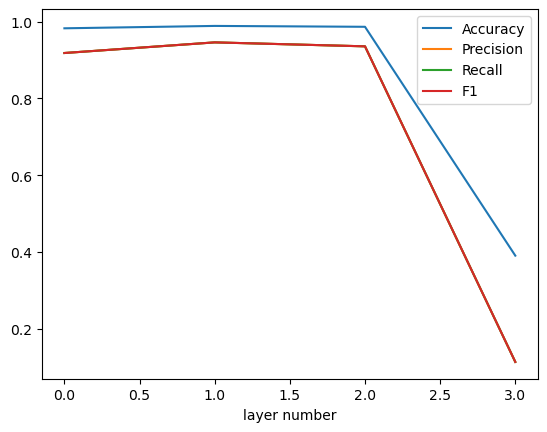

In [34]:
x=np.array(range(0,4))
for i, name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    plt.plot(x, a[i], label = name)
plt.xlabel('layer number')
plt.legend()
plt.show

# 发现两层时准确率比较高

# 下面对单层网络的神经元与指标关系进行研究

In [35]:
batch_size, lr, num_epochs = 256, 0.1, 10
a = []
for i in range(5,9):
    num_neuron = 2**i

    net = nn.Sequential(nn.Flatten(),
                          nn.Linear(784, num_neuron),
                          nn.ReLU(),
                          nn.Linear(num_neuron,10),
                          nn.Softmax(dim=1)
                        )
    net.apply(init_weights)
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train(net,train_iter,cross_entropy,trainer,num_epochs)
    tp, fp, tn, fn = test(net, test_iter)
    note = result(tp, fp, tn, fn)
    if i==5:
        a=np.array(note)
    else :
        a = np.vstack([a,note])

In [36]:
a = a.transpose()

<function matplotlib.pyplot.show(close=None, block=None)>

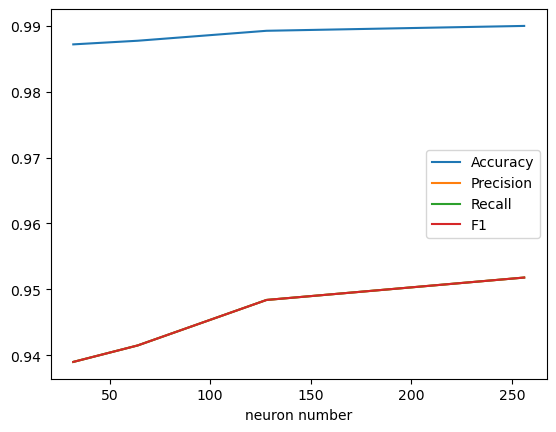

In [37]:
x=np.array([2**i for i in range(5,9)])
for i, name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    plt.plot(x, a[i], label = name)
plt.xlabel('neuron number')
plt.legend()
plt.show

# 分析图发现单层时神经元数量对准确率影响不大

# 下面研究双层图的指标与训练轮数的关系

In [38]:
e = nn.Sequential(nn.Flatten(),
                          nn.Linear(784,64),
                          nn.ReLU(),
                          nn.Linear(64,64),
                          nn.ReLU(),
                          nn.Linear(64,10),
                          nn.Softmax(dim=1)
                        )
e.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=64, bias=True)
  (2): ReLU()
  (3): Linear(in_features=64, out_features=64, bias=True)
  (4): ReLU()
  (5): Linear(in_features=64, out_features=10, bias=True)
  (6): Softmax(dim=1)
)

In [39]:
batch_size, lr, _ = 256, 0.1, 10
trainer = torch.optim.SGD(e.parameters(), lr=lr)
a = []
for num_epoch in range(0,5):
    train(e,train_iter,cross_entropy,trainer,num_epoch)
    tp, fp, tn, fn = test(e, test_iter)
    note = result(tp, fp, tn, fn)
    if num_epoch == 0:
        a=np.array(note)
    else :
        a=np.vstack([a, note])
a=a.transpose()

<function matplotlib.pyplot.show(close=None, block=None)>

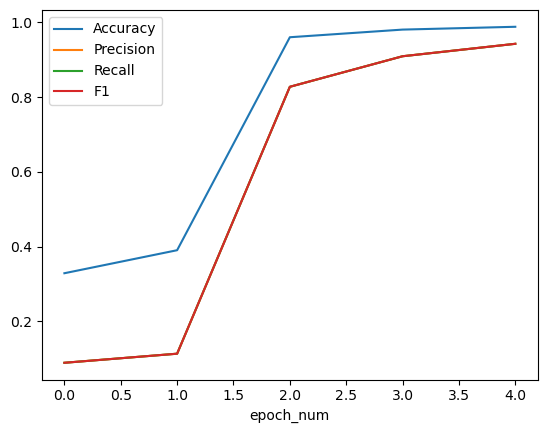

In [40]:
x = range(0,5)
for i, name in enumerate(['Accuracy', 'Precision', 'Recall', 'F1']):
    plt.plot(x, a[i], label = name)
plt.xlabel('epoch_num')
plt.legend()
plt.show

# 两层时准确率随训练轮数增加而增加,训练两次时准确率很快增加。之后增速变慢